# Downstream analysis pySCENIC

Downstream analysis using the loom file generated from [this notebook]("./pySCENIC_NK_mm.ipynb")

In [45]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from pyscenic.utils import load_motifs
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

import warnings
warnings.filterwarnings('ignore')

In [46]:
# path to loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = "Results/mm_scenic_integrated-output.loom"

In [47]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)



## Extract relevant data from the integrated loom file


In [48]:


# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)



In [49]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)



In [50]:
# cell annotations from the loom column attributes:
cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.new_label, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.label, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.percent_mt, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.batch, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'new_label',
 'label',
 'percent_mt',
 'nGene',
 'nUMI',
 'batch']


In [51]:
# capture embeddings:

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

dr = pd.DataFrame()
dr.index = drx.index
dr["X"] = drx
dr["Y"] = dry




In [52]:
lf.close()

### Using anndata

In [53]:
adata = sc.read( f_final_loom, validate=False)

# drop the embeddings and extra attributes from the obs object
adata.obs.drop( ['Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [54]:
adata.obsm["X_umap"] = np.array(dr)

In [55]:
sc._utils.sanitize_anndata( adata )

In [56]:
# load the regulons from a file using the load_signatures function
sig = load_signatures('Results/reg_mm.csv')
adata = add_scenic_metadata(adata, auc_mtx, sig)


Create regulons from a dataframe of enriched features.
Additional columns saved: []


### UMAP and knn graph from auc_mtx

In [57]:
with open("Results/auc_mtx.csv") as your_data:
    adata_umap = anndata.read_csv(your_data)

adata_umap.obs["label"] = adata.obs["label"]
adata_umap.obs["new_label"] = adata.obs["new_label"]
adata_umap.obs["batch"] = adata.obs["batch"]

In [58]:
sc.tl.pca(adata_umap)
sc.pp.neighbors(adata_umap, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_umap)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


In [59]:
adata_umap.var_names

Index(['ARID3A_(+)', 'ARNTL_(+)', 'ATF1_(+)', 'ATF2_(+)', 'ATF4_(+)',
       'ATF6_(+)', 'BACH1_(+)', 'BACH2_(+)', 'BCL11B_(+)', 'BCL6_(+)',
       ...
       'ZNF576_(+)', 'ZNF580_(+)', 'ZNF587_(+)', 'ZNF600_(+)', 'ZNF655_(+)',
       'ZNF669_(+)', 'ZNF680_(+)', 'ZNF708_(+)', 'ZNF770_(+)', 'ZSCAN26_(+)'],
      dtype='object', length=219)

In [60]:
adata.uns["neighbors"] = adata_umap.uns["neighbors"]
adata.uns["umap"] = adata_umap.uns["umap"]
adata.obsm = adata_umap.obsm
adata.obsp = adata_umap.obsp




In [61]:
#for n in range(1, 10,2):
#    n = n/10
#    sc.tl.leiden(adata, resolution=n)
#    sc.pl.umap(adata, color="leiden", size=10)

In [62]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


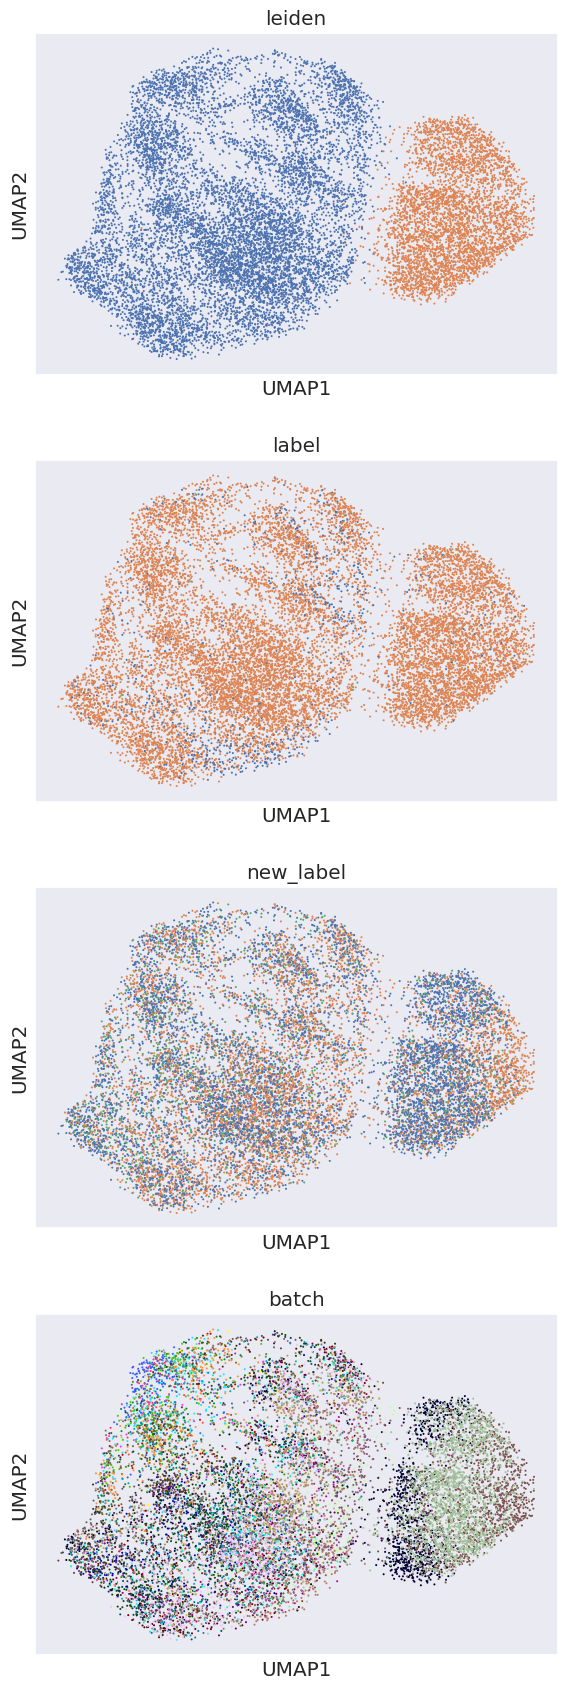

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:20)


In [63]:
sc.tl.leiden(adata, resolution=0.1)
sc.pl.umap(adata, color=["leiden","label","new_label","batch"], ncols=1, legend_loc=None)
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', pts=True)


In [64]:
DEG_0 = pd.DataFrame()

DEG_0["Symbol"] = pd.DataFrame(adata.uns["rank_genes_groups"]["names"])["0"]
DEG_0["pvals_adj"] = pd.DataFrame(adata.uns["rank_genes_groups"]["pvals_adj"])["0"]
DEG_0["logfoldchanges"] = pd.DataFrame(adata.uns["rank_genes_groups"]["logfoldchanges"])["0"]
DEG_0["abs_lfc"] = pd.DataFrame(adata.uns["rank_genes_groups"]["logfoldchanges"])["0"].abs()
DEG_0["scores"] = pd.DataFrame(adata.uns["rank_genes_groups"]["scores"])["0"]
DEG_0 = DEG_0.set_index("Symbol")

DEG_0_pts = pd.DataFrame(adata.uns["rank_genes_groups"]["pts"])["0"]
DEG_0 = pd.merge(DEG_0, DEG_0_pts,left_index=True, right_index=True)
DEG_0 = DEG_0[DEG_0["pvals_adj"] < 0.05]



Top upregulated genes in cluster 0

In [65]:
DEG_0.sort_values("scores", ascending=False).head(10)

,pvals_adj,logfoldchanges,abs_lfc,scores,0
ACTB,0.0,2.140418,2.140418,69.560486,0.970817
PFN1,0.0,1.705570,1.705570,64.782364,0.918308
RPS17,0.0,1.857072,1.857072,63.334106,0.879531
FCER1G,0.0,3.645511,3.645511,58.817116,0.729375
MT-ND2,0.0,1.227908,1.227908,57.662205,0.931738
RPL31,0.0,0.988750,0.988750,55.790730,0.918308
TMSB10,0.0,0.899633,0.899633,55.092632,0.962739
B2M,0.0,0.545283,0.545283,53.625000,0.998182
CTSW,0.0,2.216852,2.216852,52.960056,0.773806
RPL27A,0.0,0.680212,0.680212,47.157238,0.932748


Top upregulated genes in cluster 1

In [66]:
DEG_1 = pd.DataFrame()

DEG_1["Symbol"] = pd.DataFrame(adata.uns["rank_genes_groups"]["names"])["1"]
DEG_1["pvals_adj"] = pd.DataFrame(adata.uns["rank_genes_groups"]["pvals_adj"])["1"]
DEG_1["logfoldchanges"] = pd.DataFrame(adata.uns["rank_genes_groups"]["logfoldchanges"])["1"]
DEG_1["abs_lfc"] = pd.DataFrame(adata.uns["rank_genes_groups"]["logfoldchanges"])["1"].abs()
DEG_1["scores"] = pd.DataFrame(adata.uns["rank_genes_groups"]["scores"])["1"]
DEG_1 = DEG_1.set_index("Symbol")

DEG_1_pts = pd.DataFrame(adata.uns["rank_genes_groups"]["pts"])["1"]
DEG_1 = pd.merge(DEG_1, DEG_1_pts,left_index=True, right_index=True)
DEG_1 = DEG_1[DEG_1["pvals_adj"] < 0.05]
DEG_1.sort_values("scores", ascending=False).head(10)

,pvals_adj,logfoldchanges,abs_lfc,scores,1
MTRNR2L12,0.0,5.276881,5.276881,84.560699,0.989117
TPT1,0.0,1.539655,1.539655,73.874573,0.998791
METRNL,0.0,4.223544,4.223544,70.211884,0.851511
CLEC2B,0.0,2.805863,2.805863,64.722237,0.962515
JUND,0.0,3.139512,3.139512,62.893665,0.887545
LDHA,0.0,2.714975,2.714975,62.041801,0.946554
LINC01578,0.0,3.599919,3.599919,61.943695,0.786457
HIST1H4C,0.0,3.081802,3.081802,61.653877,0.866264
GNAS,0.0,2.912744,2.912744,61.189777,0.884643
HLA-A,0.0,1.118251,1.118251,60.779118,1.000000


The cells looks deviding in 2 clusters considering the TF activity, cell types, states and batches look evenly dispersed in the map. Looking at the top upregulated gene in each cluster not specific genes for cell types/states were found.

In [67]:
adata.obs["leiden"]
cellAnnot = pd.concat([cellAnnot, adata.obs["leiden"]],axis=1)

## Print top enriched TFs and motifs

In [68]:
# # helper functions (not yet integrated into pySCENIC):

# from pyscenic.utils import load_motifs
# import operator as op
# from IPython.display import HTML, display

# BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
# COLUMN_NAME_LOGO = "MotifLogo"
# COLUMN_NAME_MOTIF_ID = "MotifID"
# COLUMN_NAME_TARGETS = "TargetGenes"

# def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
#     """
#     :param df:
#     :param base_url:
#     """
#     # Make sure the original dataframe is not altered.
#     df = df.copy()
    
#     # Add column with URLs to sequence logo.
#     def create_url(motif_id):
#         return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
#     df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
#     # Truncate TargetGenes.
#     def truncate(col_val):
#         return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
#     df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
#     MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
#     pd.set_option('display.max_colwidth', 200)
#     display(HTML(df.head().to_html(escape=False)))
#     pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [69]:
df_motifs = load_motifs('Results/reg_mm.csv')

In [70]:
# sorted_tfs = df_motifs.sort_values([("Enrichment","NES")], ascending=False).index.get_level_values('TF').to_list()

# def get_unique_N(iterable, N):
#     """Yields (in order) the first N unique elements of iterable. 
#     Might yield less if data too short."""
#     seen = set()
#     for e in iterable:
#         if e in seen:
#             continue
#         seen.add(e)
#         if len(seen) == N:
#             seen = list(seen)
#             return seen

# top_five = get_unique_N(sorted_tfs, 5)
# top_five


In [71]:
# df_motifs_sel = df_motifs.iloc[ [ True if x in top_five else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [72]:
# #display_logos(df_motifs.head())
# display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False))

## Regulon specificity scores (RSS) across predicted cell types

In [73]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['label'] )
rss_cellType

,ARID3A_(+),ARNTL_(+),ATF1_(+),ATF2_(+),ATF4_(+),ATF6_(+),BACH1_(+),BACH2_(+),BCL11B_(+),BCL6_(+),...,ZNF576_(+),ZNF580_(+),ZNF587_(+),ZNF600_(+),ZNF655_(+),ZNF669_(+),ZNF680_(+),ZNF708_(+),ZNF770_(+),ZSCAN26_(+)
CD56dimCD16+ NK cells,0.850005,0.848235,0.851382,0.850924,0.847210,0.847819,0.852369,0.848943,0.853502,0.846625,...,0.849734,0.850687,0.842426,0.848558,0.845024,0.850005,0.846446,0.812869,0.842980,0.806803
CD56brightCD16- NK cells,0.240429,0.238535,0.240312,0.239989,0.241538,0.240799,0.239615,0.241268,0.237963,0.238064,...,0.240118,0.240913,0.240623,0.238787,0.240957,0.240941,0.240025,0.242565,0.240801,0.258789
NK cell progenitors,0.170507,0.170515,0.170512,0.170446,0.170832,0.170670,0.170458,0.170381,0.170398,0.170489,...,0.170609,0.170712,0.170408,0.170420,0.170640,0.170526,0.170437,0.170444,0.170371,0.170293


In [74]:
# rss_cellType.iloc[0].sort_values(ascending=False)

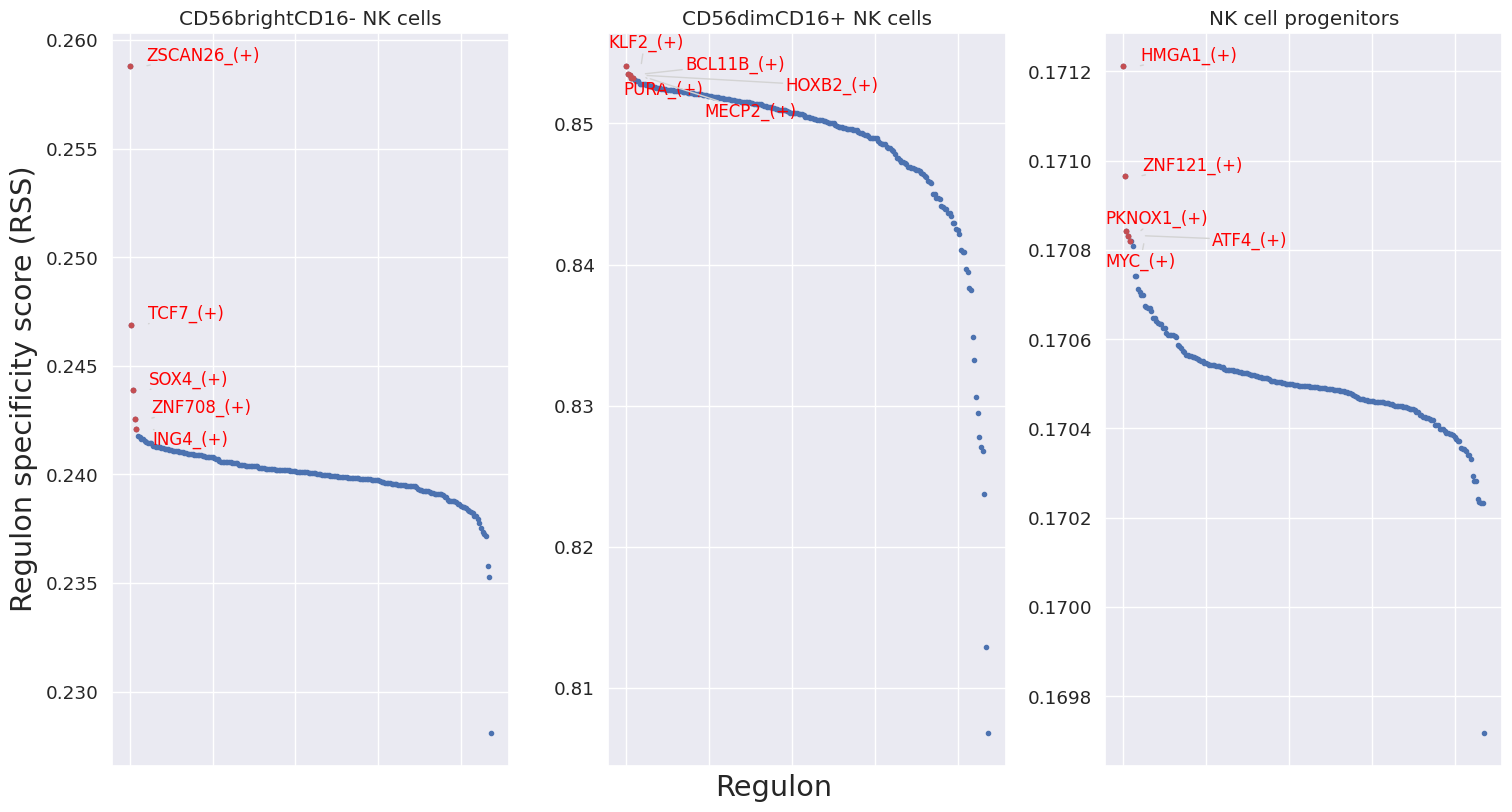

In [75]:
cats = sorted(list(set(cellAnnot['label'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(1,3,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("test_cell-state-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [76]:
# # top regulons for each cell type
# topreg = []
# for i,c in enumerate(cats):
#     topreg.extend(
#         list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
#     )
# topreg = list(set(topreg))

# topreg

In [77]:
# Z-score area under the curve for selected regulons
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)



In [78]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f



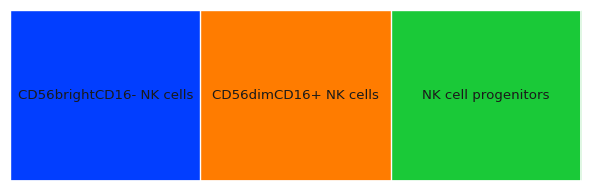

In [79]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['label'] ]

sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=2.0)
plt.savefig("test-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

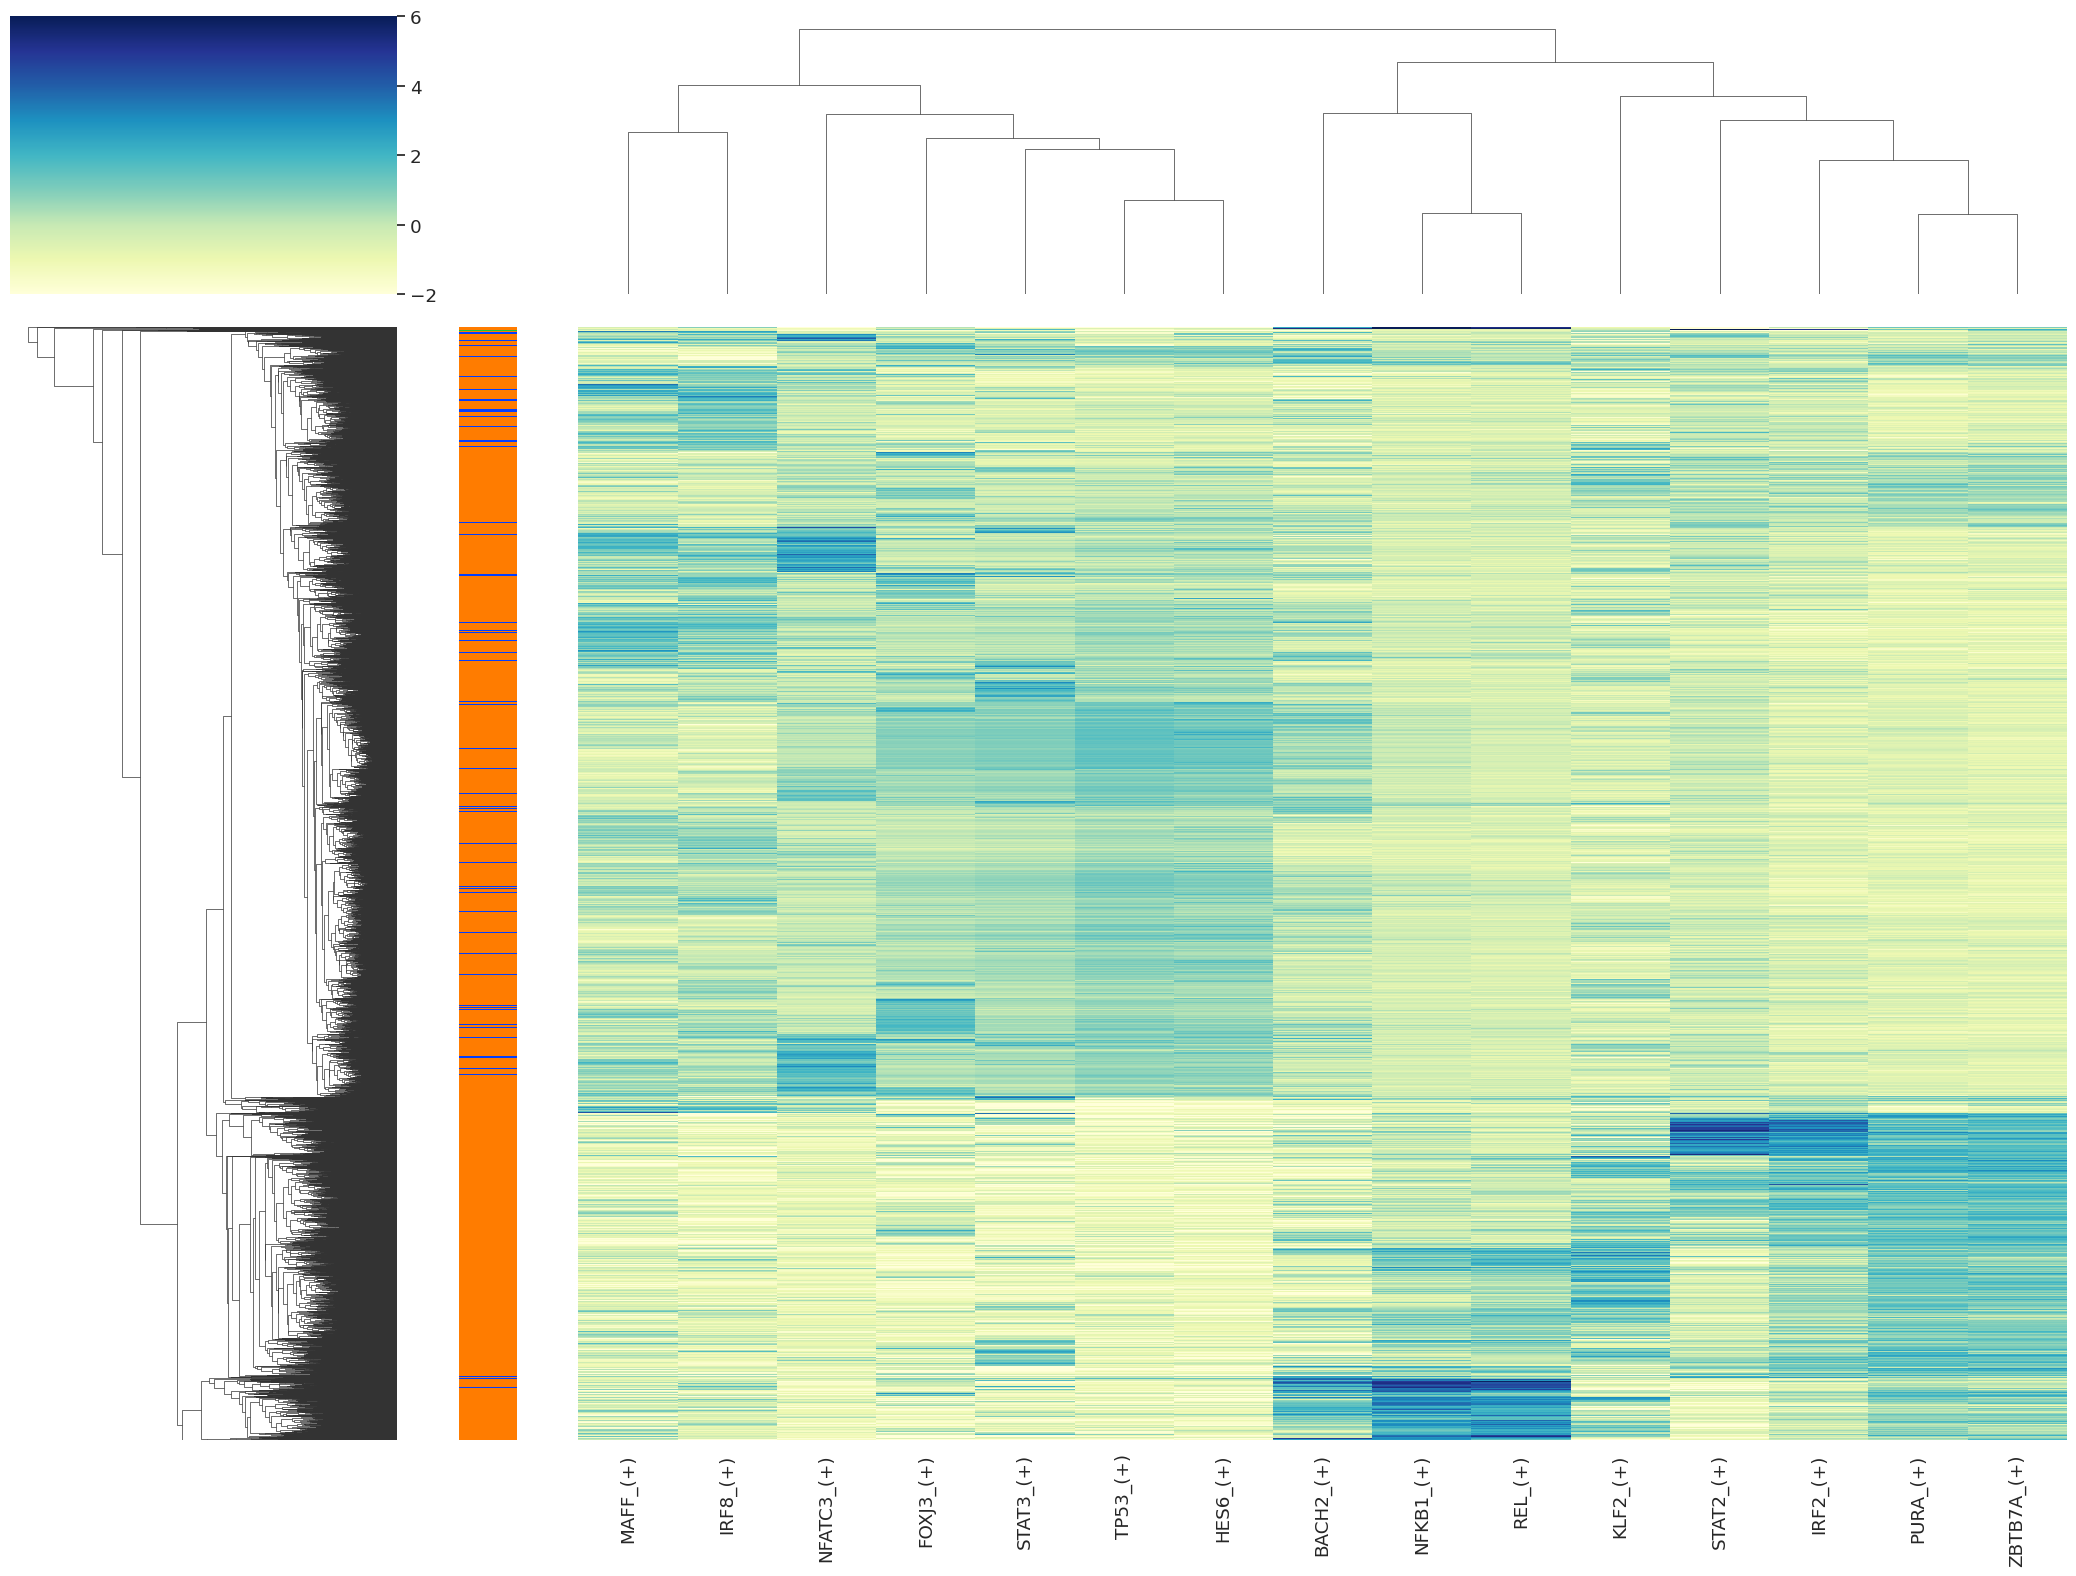

In [80]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("test-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

In [81]:
means = round(rss_cellType.T.mean(),3)
means = means.rename("mean")
sd = round(rss_cellType.T.std(),3)
sd = sd.rename("StDev")
ratio = round(adata.obs.label.value_counts()/adata.n_obs,3)
ratio = ratio.rename("Ratio")
specs = pd.concat([means,sd,ratio],axis=1)
specs

,mean,StDev,Ratio
CD56dimCD16+ NK cells,0.849,0.006,0.938
CD56brightCD16- NK cells,0.240,0.002,0.060
NK cell progenitors,0.171,0.000,0.001


The specificity for the cell types looks odd, all the TF have a narrow range of specificity for each cell types, the scores resemble the different cell types ratios. Probably the RSS is biased by the big differences of proportions.


## Regulon specificity scores (RSS) across predicted cell state

In [82]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['new_label'] )
rss_cellType

,ARID3A_(+),ARNTL_(+),ATF1_(+),ATF2_(+),ATF4_(+),ATF6_(+),BACH1_(+),BACH2_(+),BCL11B_(+),BCL6_(+),...,ZNF576_(+),ZNF580_(+),ZNF587_(+),ZNF600_(+),ZNF655_(+),ZNF669_(+),ZNF680_(+),ZNF708_(+),ZNF770_(+),ZSCAN26_(+)
NK exhausted,0.514180,0.512168,0.513665,0.513089,0.511467,0.511858,0.512965,0.510115,0.515166,0.512999,...,0.513230,0.513042,0.511271,0.510530,0.511986,0.513497,0.512413,0.505299,0.510947,0.504432
Others,0.280291,0.278536,0.279930,0.279856,0.278547,0.280299,0.279328,0.279817,0.278881,0.278929,...,0.279952,0.279569,0.279801,0.279862,0.280485,0.279689,0.280277,0.278941,0.280305,0.277005
NK resident,0.493159,0.494744,0.494433,0.494691,0.496657,0.494826,0.495591,0.497573,0.493287,0.492692,...,0.494112,0.495401,0.493328,0.495688,0.493470,0.494551,0.493261,0.486796,0.493625,0.493955


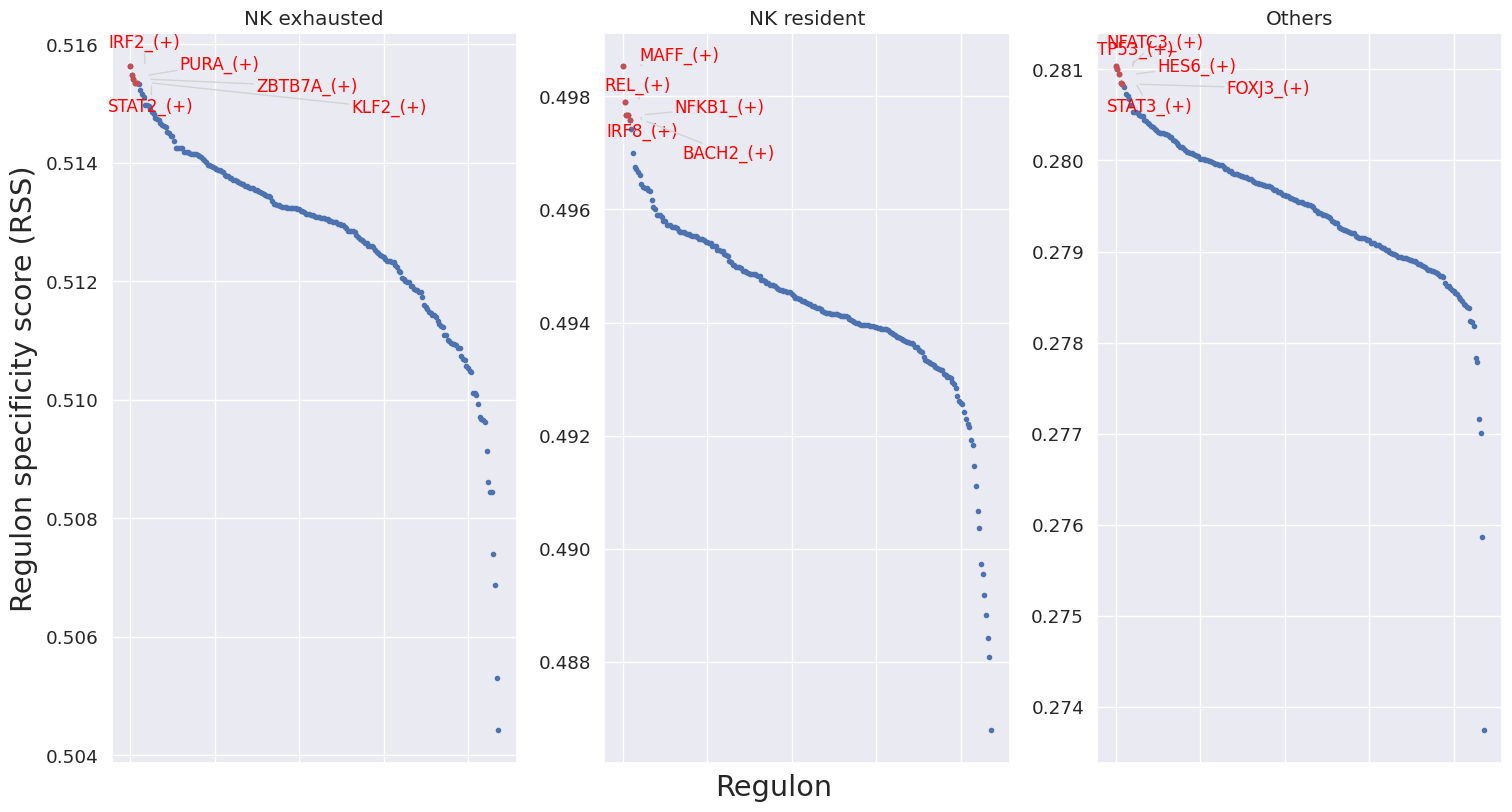

In [83]:
cats = sorted(list(set(cellAnnot['new_label'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(1,3,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("test_cell-state-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [84]:
# top regulons for each cell type
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

topreg

['STAT3_(+)',
 'TP53_(+)',
 'HES6_(+)',
 'NFKB1_(+)',
 'REL_(+)',
 'STAT2_(+)',
 'BACH2_(+)',
 'PURA_(+)',
 'FOXJ3_(+)',
 'MAFF_(+)',
 'KLF2_(+)',
 'IRF2_(+)',
 'IRF8_(+)',
 'ZBTB7A_(+)',
 'NFATC3_(+)']

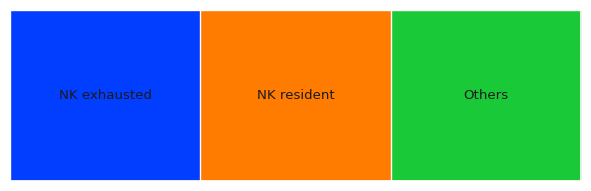

In [85]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['new_label'] ]

sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=2.0)
plt.savefig("test-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

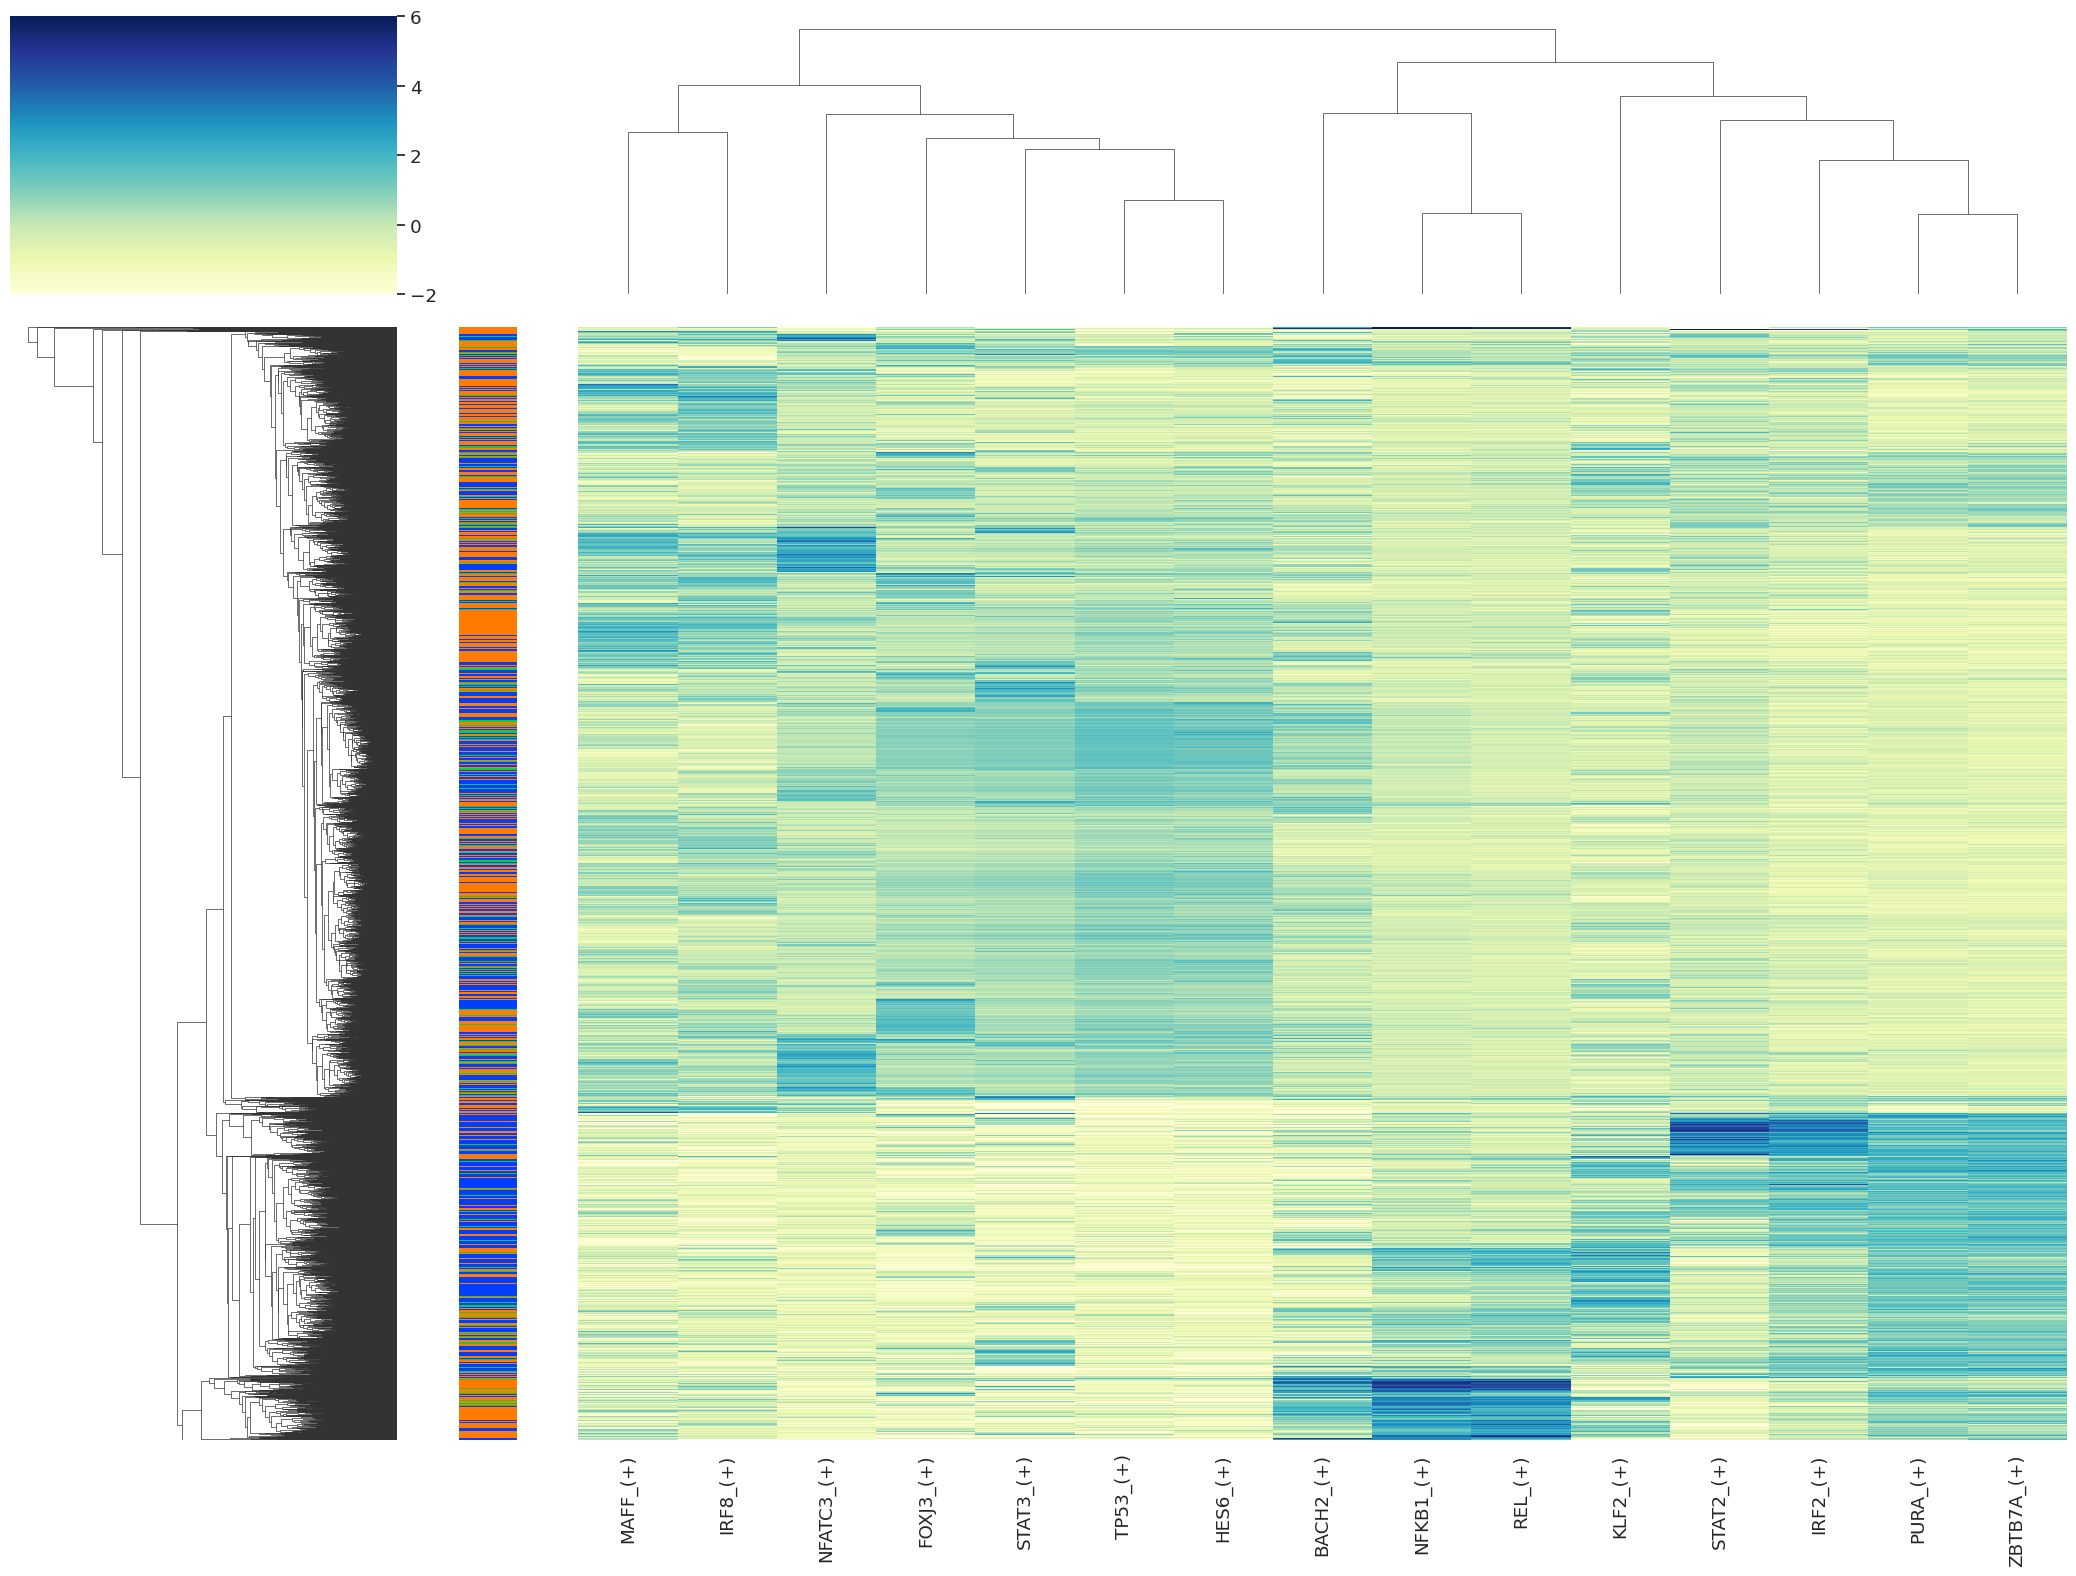

In [86]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("test-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

In [87]:
means = round(rss_cellType.T.mean(),3)
means = means.rename("mean")
sd = round(rss_cellType.T.std(),3)
sd = sd.rename("StDev")
ratio = round(adata.obs.new_label.value_counts()/adata.n_obs,3)
ratio = ratio.rename("Ratio")
specs = pd.concat([means,sd,ratio],axis=1)
specs

,mean,StDev,Ratio
NK exhausted,0.513,0.002,0.464
Others,0.279,0.001,0.105
NK resident,0.494,0.002,0.431


Similarly to the previous result, also the cell state RSS looks biased by cell type proportion. To evaluate the RSS for the cell types I am going to try to cluster the cells using the UMAP deriving from the TF activities and see if any cluster has immune checkpoint receptors as markers. Also, I am going to check if the activity is specific of the batch:

In [88]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['batch'] )
rss_cellType

,ARID3A_(+),ARNTL_(+),ATF1_(+),ATF2_(+),ATF4_(+),ATF6_(+),BACH1_(+),BACH2_(+),BCL11B_(+),BCL6_(+),...,ZNF576_(+),ZNF580_(+),ZNF587_(+),ZNF600_(+),ZNF655_(+),ZNF669_(+),ZNF680_(+),ZNF708_(+),ZNF770_(+),ZSCAN26_(+)
MGUS_CD138nCD45p_2,0.170213,0.169967,0.170155,0.170172,0.170108,0.170282,0.170086,0.170166,0.170014,0.170203,...,0.170161,0.170164,0.170153,0.170227,0.170168,0.170133,0.170530,0.170243,0.170204,0.170162
MGUS_CD138nCD45p_3,0.196614,0.194986,0.195827,0.196115,0.195782,0.196671,0.195507,0.195413,0.194816,0.195225,...,0.195980,0.196051,0.196171,0.196031,0.196006,0.195893,0.198753,0.195244,0.196330,0.194940
MGUS_CD138nCD45p_4,0.175335,0.174897,0.175127,0.175210,0.175178,0.175299,0.175018,0.175091,0.174866,0.174830,...,0.175252,0.175181,0.175165,0.175334,0.175212,0.175220,0.175841,0.175557,0.175114,0.175263
MGUS_CD138nCD45p_5,0.175017,0.174517,0.174799,0.174882,0.174855,0.175000,0.174751,0.174727,0.174608,0.174659,...,0.174881,0.174921,0.175086,0.174982,0.174887,0.174830,0.175620,0.174894,0.174805,0.174664
MGUS_CD138n_1,0.188847,0.187487,0.188278,0.188509,0.188095,0.189199,0.187787,0.188075,0.187392,0.187391,...,0.188277,0.188368,0.188488,0.187993,0.188393,0.188383,0.189862,0.187401,0.188954,0.186809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMM_CD138nCD45p_9,0.179693,0.178701,0.179380,0.179546,0.179137,0.179808,0.179064,0.179281,0.178773,0.178968,...,0.179474,0.179340,0.179698,0.179249,0.179584,0.179405,0.180390,0.179171,0.179811,0.179140
SMM_CD138n_3,0.170682,0.170368,0.170613,0.170668,0.170489,0.170703,0.170531,0.170603,0.170441,0.170563,...,0.170577,0.170577,0.170685,0.170617,0.170629,0.170596,0.170749,0.170410,0.170756,0.170510
SMM_CD138n_4,0.197817,0.195353,0.197119,0.197346,0.196790,0.197787,0.196367,0.196833,0.195841,0.196055,...,0.197095,0.196923,0.197210,0.197014,0.197529,0.197100,0.199604,0.196923,0.198150,0.195624
SMM_CD138n_5,0.172183,0.171770,0.172118,0.172185,0.171986,0.172166,0.172032,0.172124,0.171888,0.172062,...,0.172145,0.172133,0.172177,0.172085,0.172172,0.172130,0.172624,0.172051,0.172330,0.172268


In [ ]:
means = round(rss_cellType.T.mean(),3)
means = means.rename("mean")
sd = round(rss_cellType.T.std(),3)
sd = sd.rename("StDev")
ratio = round(adata.obs.batch.value_counts()/adata.n_obs,3)
ratio = ratio.rename("Ratio")
specs = pd.concat([means,sd,ratio],axis=1)
specs

No TF highly specific for a single batch where found, suggesting the TFs aren't biased by a batch effect. Probably the miss of specificity is also due to really similar cell types.

## Regulon specificity scores (RSS) across clusters

In [90]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['leiden'] )
rss_cellType

,ARID3A_(+),ARNTL_(+),ATF1_(+),ATF2_(+),ATF4_(+),ATF6_(+),BACH1_(+),BACH2_(+),BCL11B_(+),BCL6_(+),...,ZNF576_(+),ZNF580_(+),ZNF587_(+),ZNF600_(+),ZNF655_(+),ZNF669_(+),ZNF680_(+),ZNF708_(+),ZNF770_(+),ZSCAN26_(+)
0,0.668364,0.648211,0.665407,0.665909,0.663701,0.672072,0.656969,0.661738,0.647202,0.646621,...,0.669516,0.665953,0.669629,0.661312,0.669083,0.666382,0.666155,0.652306,0.673561,0.655372
1,0.404054,0.421789,0.407386,0.406495,0.407872,0.399912,0.415552,0.410322,0.424912,0.422415,...,0.402726,0.406958,0.399508,0.409143,0.401473,0.406216,0.404223,0.401747,0.396315,0.403688


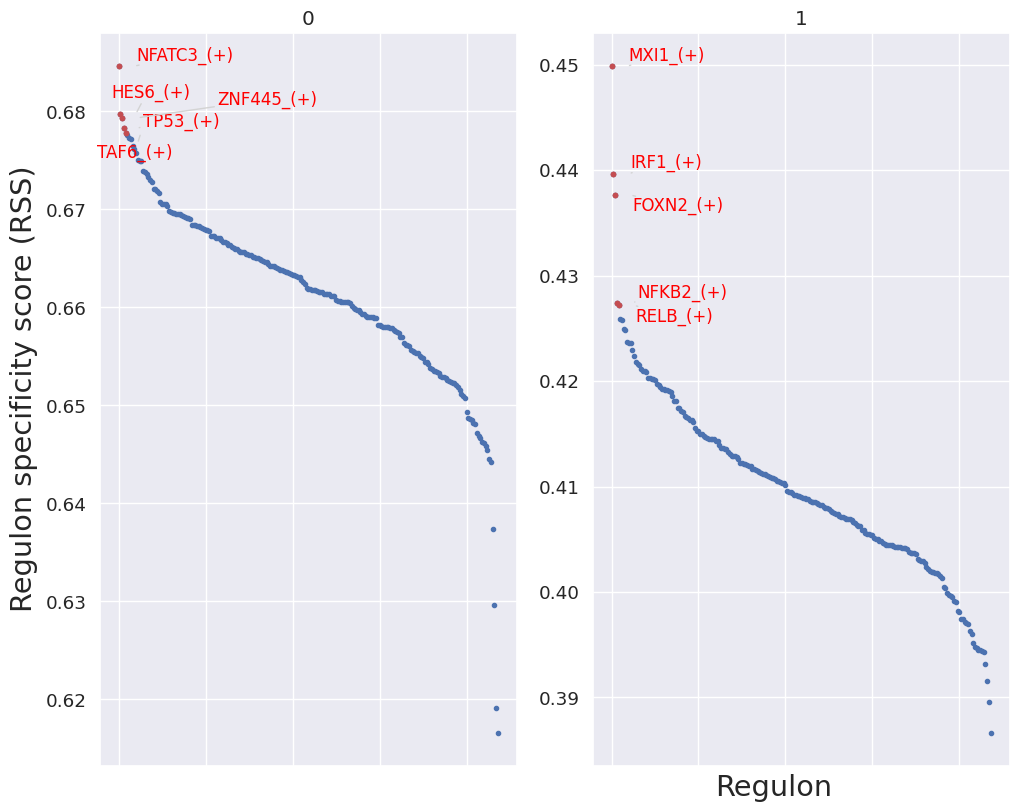

In [91]:
cats = sorted(list(set(cellAnnot['leiden'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(1,3,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("test_cell-state-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [92]:
# top regulons for each cell type
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

topreg

['TP53_(+)',
 'MXI1_(+)',
 'FOXN2_(+)',
 'RELB_(+)',
 'IRF1_(+)',
 'TAF6_(+)',
 'NFKB2_(+)',
 'HES6_(+)',
 'ZNF445_(+)',
 'NFATC3_(+)']

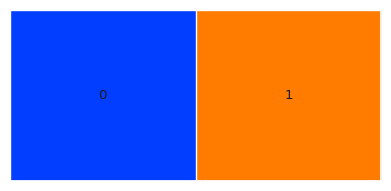

In [93]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['leiden'] ]

sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=2.0)
plt.savefig("test-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

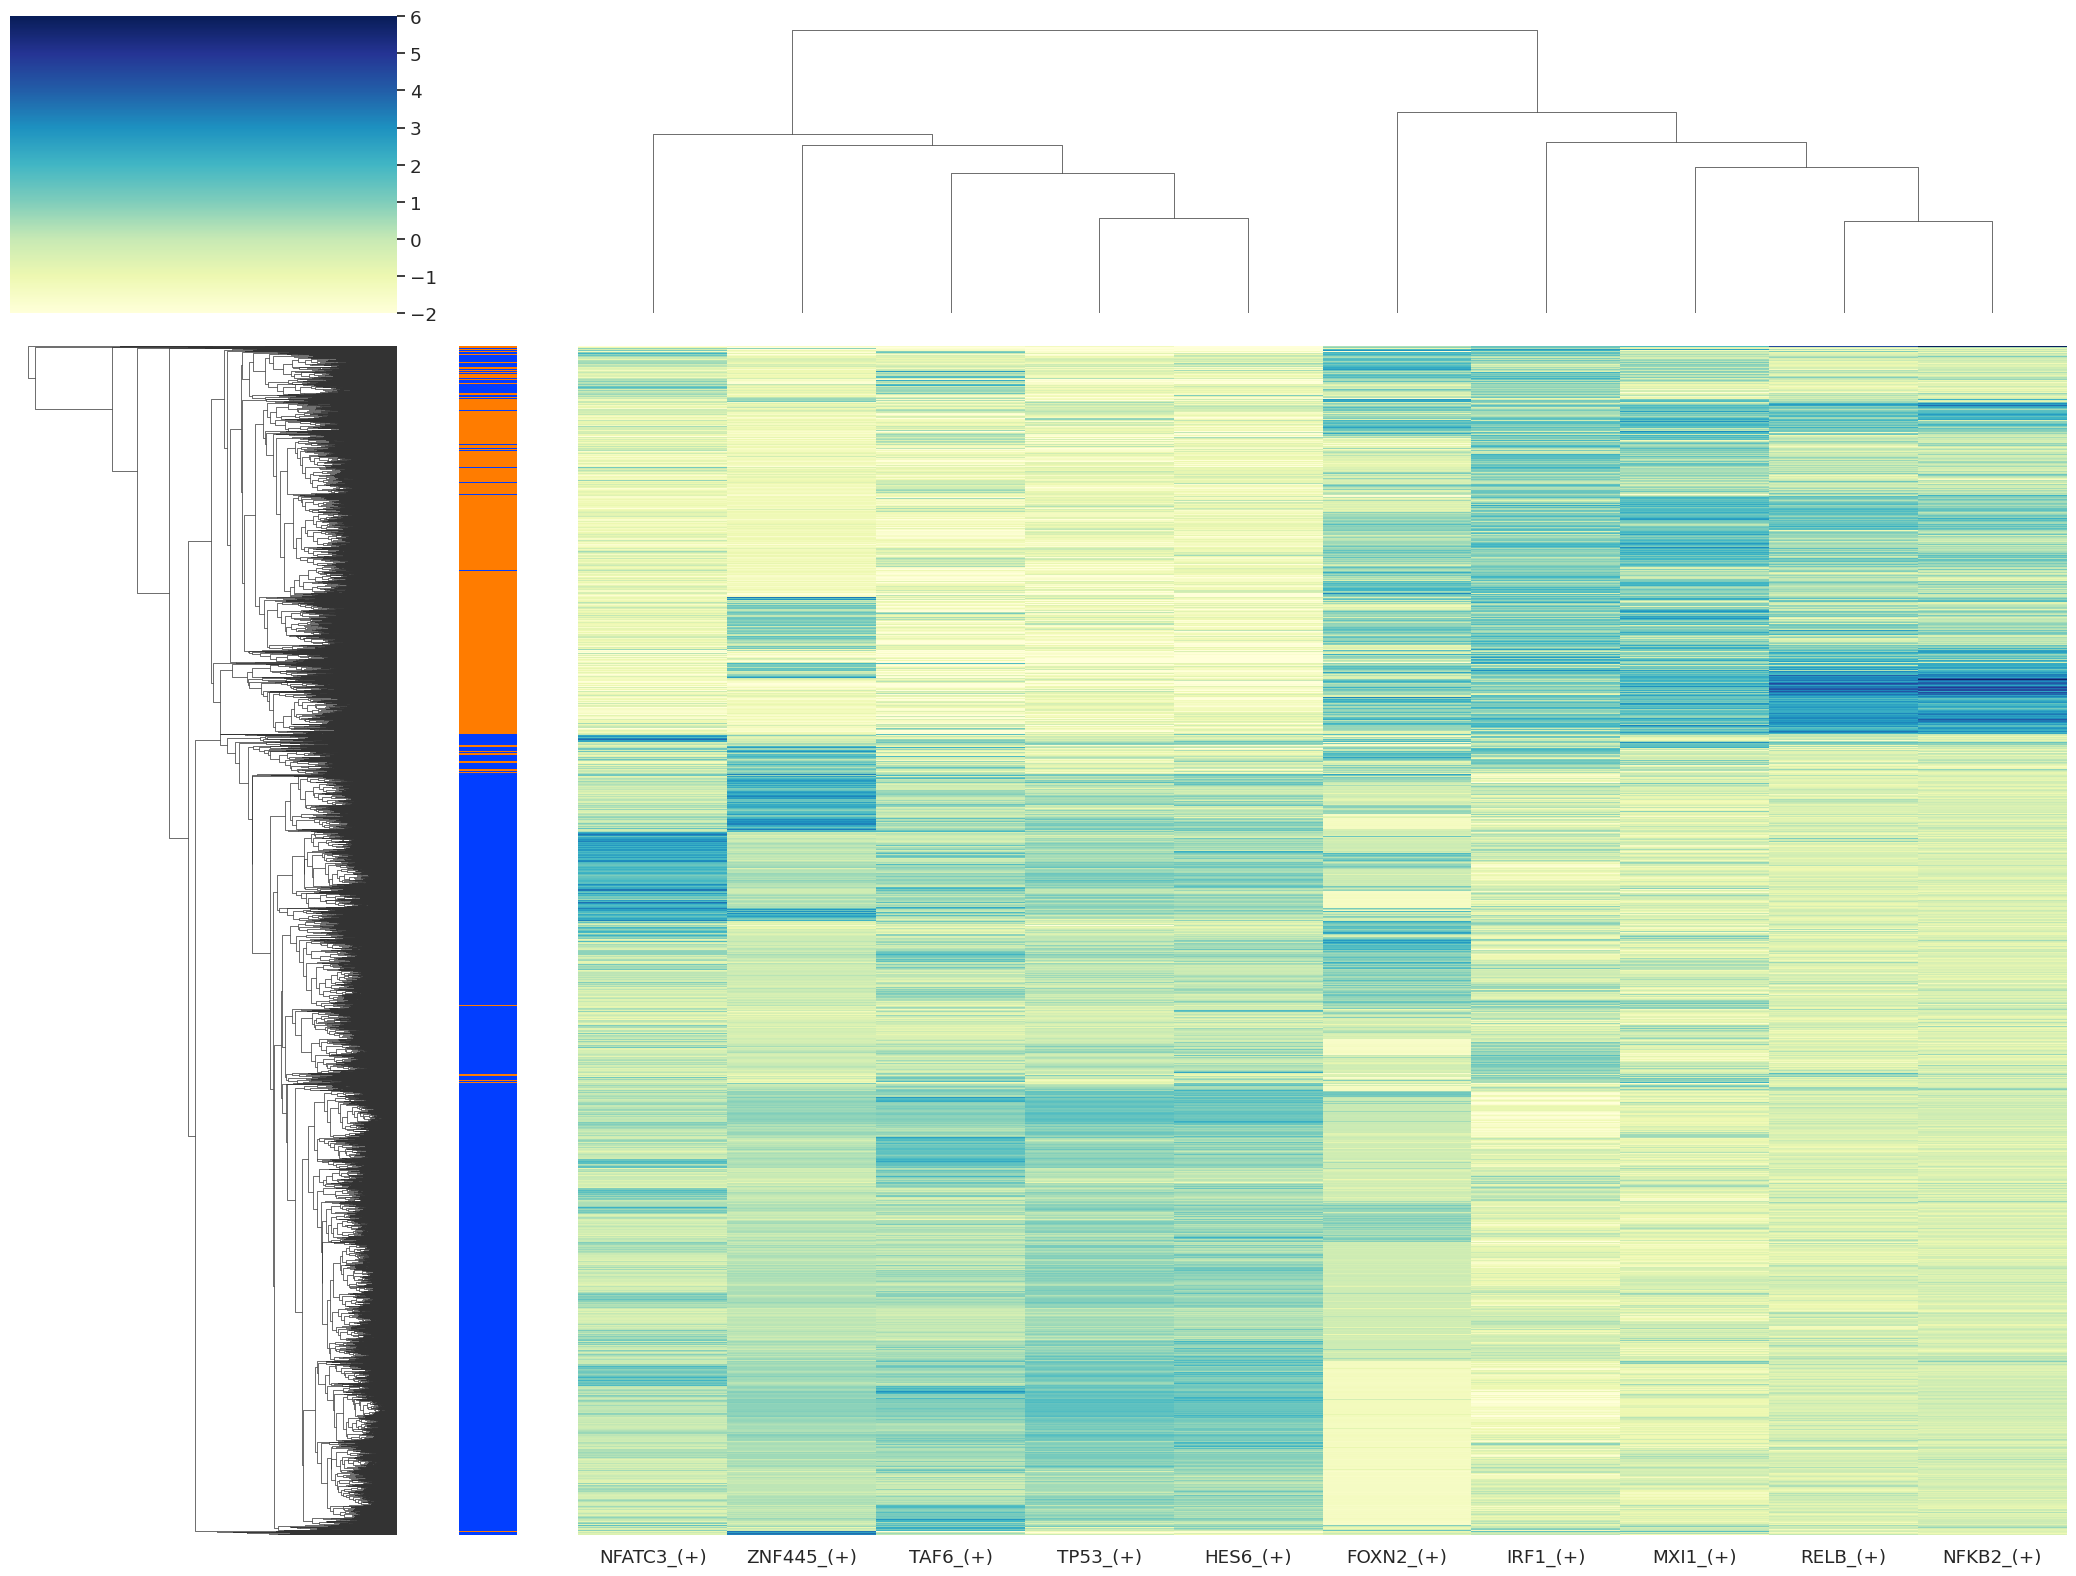

In [94]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("test-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

In [95]:
means = round(rss_cellType.T.mean(),3)
means = means.rename("mean")
sd = round(rss_cellType.T.std(),3)
sd = sd.rename("StDev")
ratio = round(adata.obs.leiden.value_counts()/adata.n_obs,3)
ratio = ratio.rename("Ratio")
specs = pd.concat([means,sd,ratio],axis=1)
specs

,mean,StDev,Ratio
0,0.662,0.009,0.705
1,0.410,0.009,0.295


Even if not really specific to immune exhaustion or cell types, the top upregulated regulons in cluster 0 and 1 looks cluster together, let's look for other metrics including area under the curve

In [ ]:
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=25 )
binary_mtx.head()

In [ ]:
top_0 = rss_cellType.iloc[0].sort_values(ascending=False).head(5).index.tolist()
top_1 = rss_cellType.iloc[1].sort_values(ascending=False).head(5).index.tolist()

## AUC top enriched TF in cluster 0

In [ ]:
top_0

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ top_0[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ auc_thresholds[ top_0[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( top_0[i] )
    ax.set_xlabel('')
    
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()



## AUC top enriched TF in cluster 1

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ top_1[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ auc_thresholds[ top_1[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( top_1[i] )
    ax.set_xlabel('')
    
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()



Also the AUC doesn't show numerous cells enriched with the regulons found, anyway I am going to save some the top 5 regulons for each cluster to have them available for other analys

In [ ]:
# from pyscenic.utils import modules_from_adjacencies
# modules = list(modules_from_adjacencies(adjacencies, exprMat))

In [ ]:
# tf = 'IRF2'
# tf_mods = [ x for x in modules if x.transcription_factor==tf ]

# for i,mod in enumerate( tf_mods ):
#     print( f'{tf} module {str(i)}: {len(mod.genes)} genes' )
# print( f'{tf} regulon: {len(regulons[tf+"_(+)"])} genes' )

In [ ]:
# [x.transcription_factor for x in modules if x.transcription_factor=="IRF2"]

In [ ]:
cluster0 = {}
for item in top_0:
    cluster0[item] = regulons[item]

with open("Results/regulons_cluster0.json", "w") as outfile:
    json.dump(cluster0, outfile)
    
pd.DataFrame.from_dict(cluster0, orient="index").T.to_csv("Results/regulons_cluster0.csv", index=False)

cluster1 = {}
for item in top_1:
    cluster1[item] = regulons[item]

with open("Results/regulons_cluster1.json", "w") as outfile:
    json.dump(cluster1, outfile)

pd.DataFrame.from_dict(cluster1, orient="index").T.to_csv("Results/regulons_cluster1.csv", index=False)
